**Task:** Housing Prices Prediction

**Data Source:**  [https://www.kaggle.com/datasets/yasserh/housing-prices-dataset/data]


**Objective:**

1. Data cleaning and Exploratory Data Analysis (EDA).
2. Feature selection. 
3. Regression models to predict house prices.
4. Results visualization and Interpretations.
5. Model evaluation (R2, MAE, and RMSE).

## Data and Libraries Import

In [51]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from category_encoders import OneHotEncoder
#from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [52]:
# Load the data
data = pd.read_csv("Data/Housing.csv")

In [53]:
# Inspect the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [54]:
# View the first 5 rows
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


## Exploratory Data Analysis (EDA)

Numerical Variables

In [55]:
# Visualize the multicollinearity between the numerical variables in a Table
m_corr = data.select_dtypes("number").drop(columns="price").corr()
m_corr

,area,bedrooms,bathrooms,stories,parking
area,1.000000,0.151858,0.193820,0.083996,0.352980
bedrooms,0.151858,1.000000,0.373930,0.408564,0.139270
bathrooms,0.193820,0.373930,1.000000,0.326165,0.177496
stories,0.083996,0.408564,0.326165,1.000000,0.045547
parking,0.352980,0.139270,0.177496,0.045547,1.000000


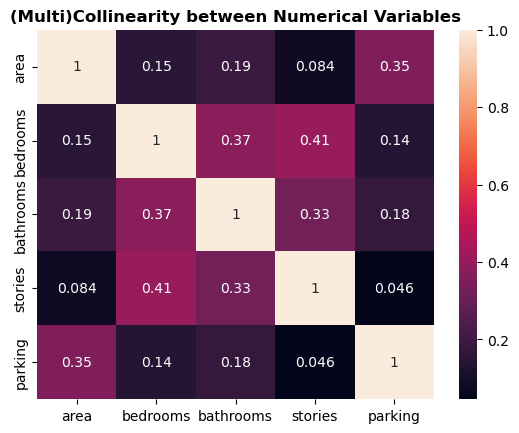

In [126]:
# Visualize the multicollinearity between the numerical variables using an HeatMap
sns.heatmap(m_corr, annot=True)
plt.title("(Multi)Collinearity between Numerical Variables", fontweight= "bold");

In [57]:
# Examine the correlation between the numerical variables and the target (price)
corr = data.select_dtypes("number").corr()
corr

,price,area,bedrooms,bathrooms,stories,parking
price,1.000000,0.535997,0.366494,0.517545,0.420712,0.384394
area,0.535997,1.000000,0.151858,0.193820,0.083996,0.352980
bedrooms,0.366494,0.151858,1.000000,0.373930,0.408564,0.139270
bathrooms,0.517545,0.193820,0.373930,1.000000,0.326165,0.177496
stories,0.420712,0.083996,0.408564,0.326165,1.000000,0.045547
parking,0.384394,0.352980,0.139270,0.177496,0.045547,1.000000


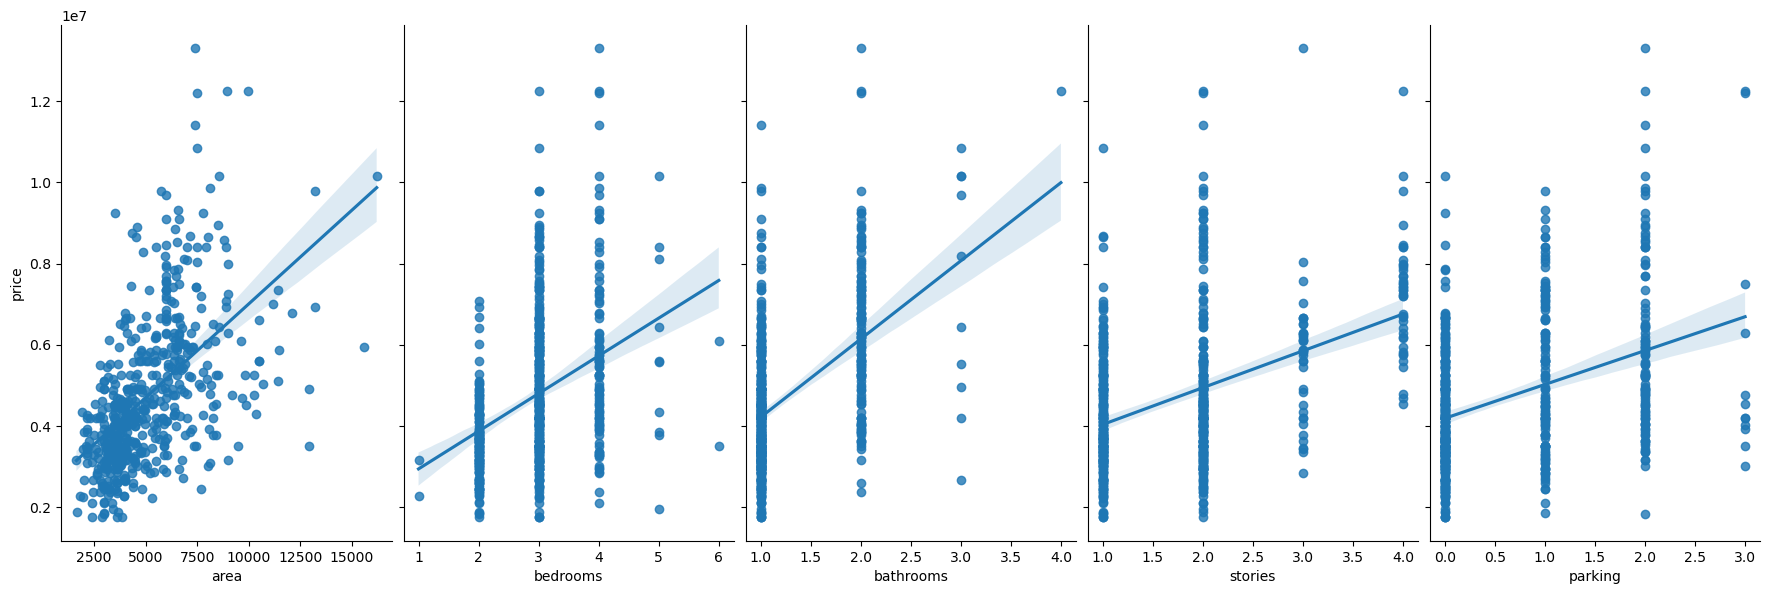

In [58]:
# Visualize the correlation between the numerical variables and the target (price) using Scatter plots
sns.pairplot(data, x_vars=["area", "bedrooms", "bathrooms", "stories", "parking"], y_vars="price",height=6, aspect=0.6, kind="reg")

**Insights from the correlation analysis:**

"Stories", "bedrooms", and "bathrooms" are moderately correlated with one another.

All the features have moderately positive correlation with the target (price)

As expected, "area" is the most correlated feature with "price": 0.535997

Only  "bedrooms" has a low correlation: 0.366494

**Categorical Variables**

In [59]:
# Check for cardinality among the categorical variables
data.select_dtypes("object").nunique()

mainroad            2
guestroom           2
basement            2
hotwaterheating     2
airconditioning     2
prefarea            2
furnishingstatus    3
dtype: int64

In [60]:
category_var = pd.DataFrame(data.select_dtypes("object"))
category_var

,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus
0,yes,no,no,no,yes,yes,furnished
1,yes,no,no,no,yes,no,furnished
2,yes,no,yes,no,no,yes,semi-furnished
3,yes,no,yes,no,yes,yes,furnished
4,yes,yes,yes,no,yes,no,furnished
...,...,...,...,...,...,...,...
540,yes,no,yes,no,no,no,unfurnished
541,no,no,no,no,no,no,semi-furnished
542,yes,no,no,no,no,no,unfurnished
543,no,no,no,no,no,no,furnished


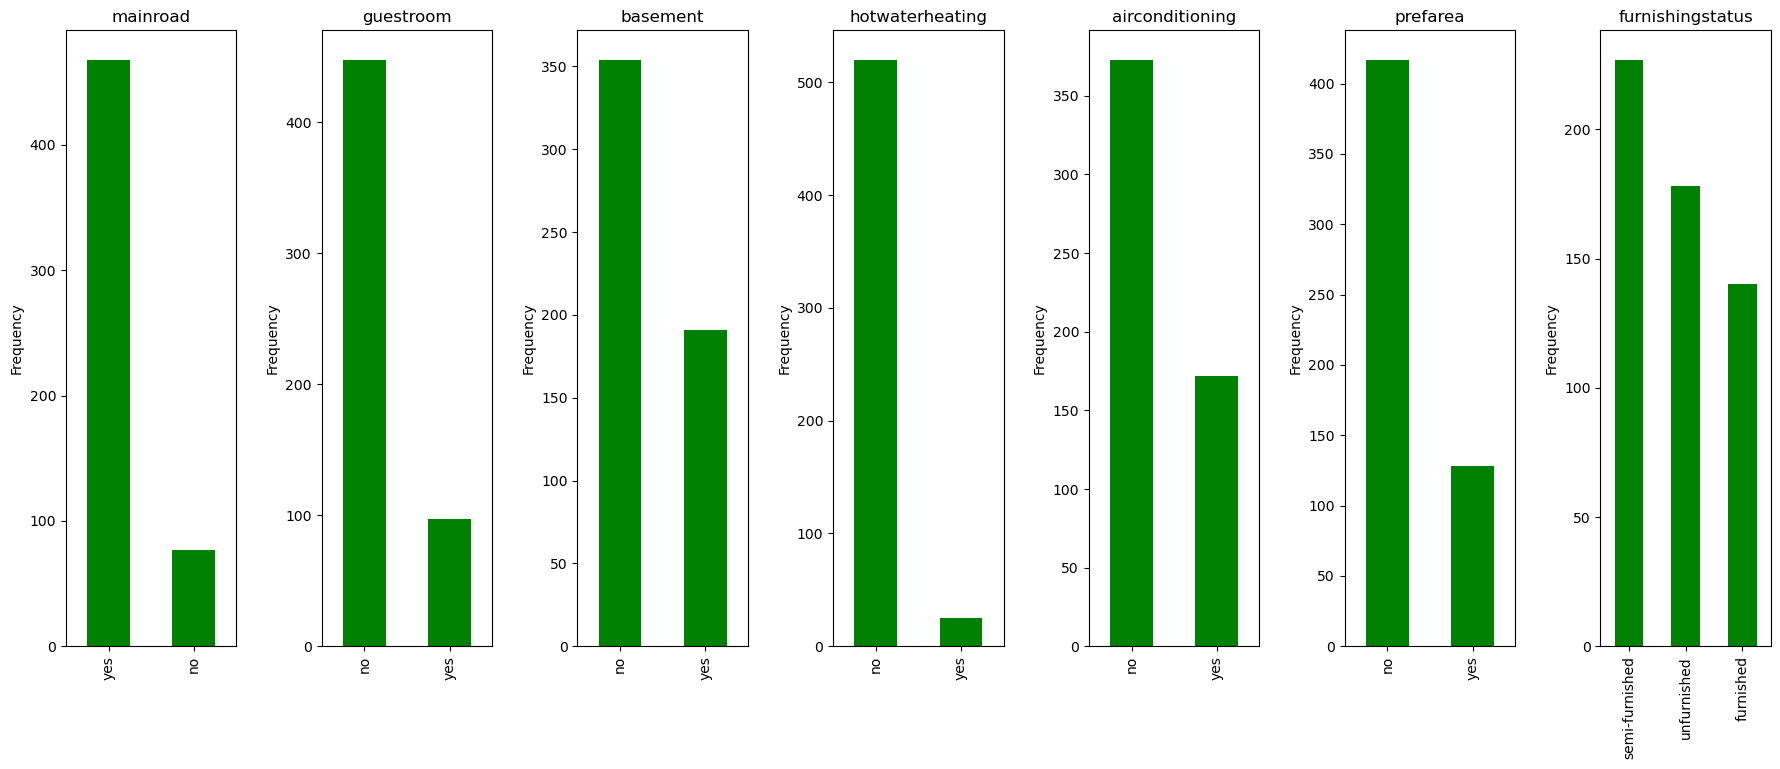

In [61]:
# Visualize the categorical variables using bar charts
category_var = pd.DataFrame(data.select_dtypes("object"))

fig, ax = plt.subplots(1,len(category_var.columns), figsize=(22, 8))

if len(category_var.columns) ==1:
    ax = [ax]


for ax,col in zip(ax, category_var.columns):
    category_var[col].value_counts().plot(kind="bar", ax=ax,title=col, xlabel="",ylabel= "Frequency",  color="green")

plt.subplots_adjust(wspace=0.5)

**Insights from the cardinality analysis:**

All the categorical features have low cardinality, expect "furnishingstatus"

Most of the houses do not have guestroom, hotwaterheating, airconditioning, and prefarea.

## Feature Selection

1. Using all the features

In [62]:
# Split the data into features and target
X= data[["area", "bedrooms", "bathrooms", "stories", "parking", "mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "prefarea", "furnishingstatus"]]
y= data["price"]

In [63]:
# Check the shapes of the feature matrix and target vector
print(X.shape)
print(y.shape)

(545, 12)
(545,)


In [64]:
# Instatiate the model
lr_model = LinearRegression()


In [65]:
# Transform the categorical variables to numerical values
column_trans = make_column_transformer(
    (OneHotEncoder(), ["mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "prefarea", "furnishingstatus"]),
    remainder="passthrough"
)

column_trans

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(),
                                 ['mainroad', 'guestroom', 'basement',
                                  'hotwaterheating', 'airconditioning',
                                  'prefarea', 'furnishingstatus'])])

In [66]:
# Inspect the result of the categorical data transformation.
pd.DataFrame(column_trans.fit_transform(X), columns=column_trans.get_feature_names_out()).head()

,onehotencoder__mainroad_1,onehotencoder__mainroad_2,onehotencoder__guestroom_1,onehotencoder__guestroom_2,onehotencoder__basement_1,onehotencoder__basement_2,onehotencoder__hotwaterheating_1,onehotencoder__hotwaterheating_2,onehotencoder__airconditioning_1,onehotencoder__airconditioning_2,onehotencoder__prefarea_1,onehotencoder__prefarea_2,onehotencoder__furnishingstatus_1,onehotencoder__furnishingstatus_2,onehotencoder__furnishingstatus_3,remainder__area,remainder__bedrooms,remainder__bathrooms,remainder__stories,remainder__parking
0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,7420,4,2,3,2
1,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,8960,4,4,4,3
2,1,0,1,0,0,1,1,0,0,1,1,0,0,1,0,9960,3,2,2,2
3,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,7500,4,2,2,3
4,1,0,0,1,0,1,1,0,1,0,0,1,1,0,0,7420,4,1,2,2


In [67]:
# Compare the transformed categorical data with the original data to ensure that the transformation is correct
X.head()

,area,bedrooms,bathrooms,stories,parking,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus
0,7420,4,2,3,2,yes,no,no,no,yes,yes,furnished
1,8960,4,4,4,3,yes,no,no,no,yes,no,furnished
2,9960,3,2,2,2,yes,no,yes,no,no,yes,semi-furnished
3,7500,4,2,2,3,yes,no,yes,no,yes,yes,furnished
4,7420,4,1,2,2,yes,yes,yes,no,yes,no,furnished


In [68]:
# Build a pipeline that that perform the data transformation in line with model instatiation
pipe = make_pipeline(
    column_trans,
    lr_model
    )

In [69]:
# 30-fold cross-validation with all the features (MAE)
mae_score = cross_val_score(pipe,
                X,
                y,
                cv=30,
                scoring="neg_mean_absolute_error")

avg_mae_score = -mae_score.mean().round(3)
avg_mae_score

829705.909

In [70]:
# 30-fold cross-validation with all the features (RMSE)
mse_score = cross_val_score(pipe,
                X,
                y,
                cv=30,
                scoring="neg_root_mean_squared_error")

mse_score = - mse_score
rmse_score = np.sqrt(mse_score)
avg_rmse_score = rmse_score.mean().round(3)
avg_rmse_score

989.23

2. Drop categorical features with low cardinality

In [71]:
# New feature list
X_2 = data[["area", "bedrooms", "bathrooms", "stories", "parking", "furnishingstatus"]]

In [72]:
# Transform the categorical variables to numerical values
column_trans_2 = make_column_transformer(
    (OneHotEncoder(), ["furnishingstatus"]),
    remainder="passthrough"
)

In [73]:
# Build a pipeline that convert categorical variables to numerical and instatiate the linear regression model 
pipe_2 = make_pipeline(
    column_trans_2,
    lr_model
    )

In [74]:
# 30-fold cross-validation with six features
score_2 = cross_val_score(pipe_2,
                X_2,
                y,
                cv=30,
                scoring="neg_mean_absolute_error")

score_2 = - score_2
avg_score_2 = score_2.mean().round(3)
avg_score_2

931490.891

MAE with all features: 829,705.909

MAE with six features: 931,490.891

The lower MAE is better. Thus all the features will be used for train and testing the model.

## Training and Predictions Using Linear Regression Model

In [75]:
# Using the train and test split with 70% training sample and 30% testing sample
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=5)

In [76]:
X

,area,bedrooms,bathrooms,stories,parking,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus
0,7420,4,2,3,2,yes,no,no,no,yes,yes,furnished
1,8960,4,4,4,3,yes,no,no,no,yes,no,furnished
2,9960,3,2,2,2,yes,no,yes,no,no,yes,semi-furnished
3,7500,4,2,2,3,yes,no,yes,no,yes,yes,furnished
4,7420,4,1,2,2,yes,yes,yes,no,yes,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...
540,3000,2,1,1,2,yes,no,yes,no,no,no,unfurnished
541,2400,3,1,1,0,no,no,no,no,no,no,semi-furnished
542,3620,2,1,1,0,yes,no,no,no,no,no,unfurnished
543,2910,3,1,1,0,no,no,no,no,no,no,furnished


In [77]:
# Check the shape of the training and test data
print(X_train.shape) 
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(381, 12)
(381,)
(164, 12)
(164,)


In [78]:
# Create a pipeline model that transform the categorical variables and instatiate the predictor
model_pipe_lr = make_pipeline(
    OneHotEncoder(),
    LinearRegression()
)

In [79]:
# Fit the training data into the pipepline model
model_pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['mainroad', 'guestroom', 'basement',
                                     'hotwaterheating', 'airconditioning',
                                     'prefarea', 'furnishingstatus'])),
                ('linearregression', LinearRegression())])

In [80]:
# Make predictions using the test samples
y_pred_lr = model_pipe_lr.predict(X_test)

## Evaluation of Prediction Accuracy of the Linear Regression (LR) Model

The Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R**2 score is used for the accuracy evaluation

In [82]:
# Compute the mean absolute error for the LR model
mae_lr = mean_absolute_error(y_test, y_pred_lr)
print (f"The Mean Absolute Error (MAE) for the LR model is: {mae_lr:.2f}")

The Mean Absolute Error (MAE) for the LR model is: 713192.94


In [84]:
# Compute the root mean squared error for the LR model
mse_lr = mean_squared_error(y_test, y_pred_lr)
print (f"The Mean Squared Error (MSE) for the LR model is: {mse_lr:.2f}")

rmse_lr = np.sqrt(mse_lr)
print (f"The Root Mean Squared Error (RMSE) for the LR model is: {rmse_lr:.3}")

The Mean Squared Error (MSE) for the LR model is: 823898911494.51
The Root Mean Squared Error (RMSE) for the LR model is: 9.08e+05


In [105]:
# Compute the R2 score
r2_lr = r2_score(y_test, y_pred_lr)
print (f"The R2 score for the LR model is: {r2_lr:.2f}")

The R2 score for the LR model is: 0.67


In [86]:
# Compare the actual values and the predicted values from the LR model
len(y_test) == len(y_pred_lr)

True

In [92]:
# Compare the actual values and the predicted values from the LR model
print(y_pred_lr.dtype)
print(y_test.dtype)

y_pred_lr= y_pred_lr.astype(int)
print(type(y_pred))

df_lr = pd.DataFrame({
    "y_test": y_test,
    "y_pred_lr": y_pred_lr
})

df_lr.head()

float64
int64
<class 'numpy.ndarray'>


,y_test,y_pred_lr
286,4235000,4036086
375,3640000,4259703
409,3430000,3207986
301,4200000,4154985
199,4907000,3997118


Text(0.05, 0.95, 'R² = 0.67')

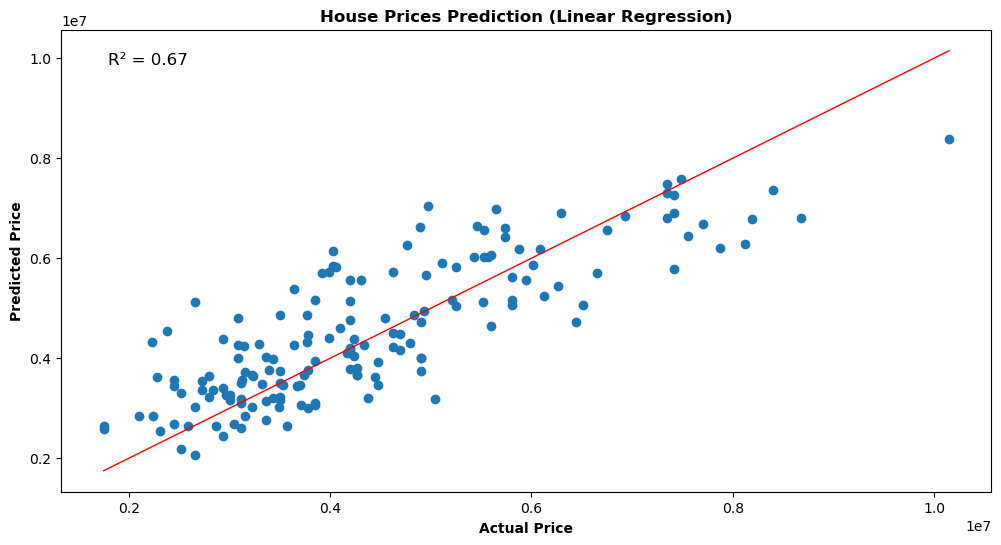

In [128]:
# Visualize the actual and predicted values from the LR model
plt.figure(figsize=(12,6))
plt.scatter(y_test, y_pred_lr)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=1)

# Add labels to the plot
plt.title("House Prices Prediction (Linear Regression)", fontweight="bold")
plt.xlabel("Actual Price", fontweight="bold")
plt.ylabel("Predicted Price", fontweight="bold")
plt.text(0.05, 0.95, f'R² = {r2_lr:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

In [90]:
# Extract the intercept a
intercept = model_pipe_lr.named_steps["linearregression"].intercept_
intercept = intercept.round(2)

# Extract the coefficients
coefficients = model_pipe_lr.named_steps["linearregression"].coef_
coefficients = coefficients.round(2)
# Extract the feature names
features = model_pipe_lr.named_steps["onehotencoder"].get_feature_names_out()

In [45]:
print(len(features))

20


In [46]:
# Join the coefficients with the features
coef = pd.Series(coefficients, index=features)
print(coef[0:5])

area             228.39
bedrooms       94918.54
bathrooms    1098840.19
stories       394622.13
parking       332988.89
dtype: float64


In [47]:
# Display the regression equation
reg_equation = f"price = {intercept} "
for c, f in coef.items():
    reg_equation+= f" + {c}*{f}"

print(reg_equation)

price = 1721456.59  + area*228.39 + bedrooms*94918.54 + bathrooms*1098840.19 + stories*394622.13 + parking*332988.89 + mainroad_1*195316.8 + mainroad_2*-195316.8 + guestroom_1*-93032.56 + guestroom_2*93032.56 + basement_1*204153.17 + basement_2*-204153.17 + hotwaterheating_1*-437436.31 + hotwaterheating_2*437436.31 + airconditioning_1*-454804.21 + airconditioning_2*454804.21 + prefarea_1*340493.9 + prefarea_2*-340493.9 + furnishingstatus_1*110370.56 + furnishingstatus_2*-255567.41 + furnishingstatus_3*145196.84


## Training and Predictions Using Random Forest Model

In [93]:
# Create a pipeline and instatiate the RandomForestRegressor model 
model_pipe_rf = make_pipeline(
    OneHotEncoder(),
    RandomForestRegressor()
)

In [94]:
# Fit the training and testing data to the model
model_pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['mainroad', 'guestroom', 'basement',
                                     'hotwaterheating', 'airconditioning',
                                     'prefarea', 'furnishingstatus'])),
                ('randomforestregressor', RandomForestRegressor())])

In [95]:
# Make predictions on the testing data
y_pred_rf = model_pipe_rf.predict(X_test)

## Evaluation of Prediction Accuracy of the Random Forest Model

The Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R**2 score is used for the accuracy evaluation

In [96]:
# Compute the Mean Absolute Error for the RF model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"The mean absolute error of the RF model is: {mae_rf:.2f}")

The mean absolute error of the RF model is: 747397.56


In [98]:
# Compute the root mean squared error for the RF model
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"The mean squared error for the RF model is: {mse_rf:.2f}")

rmse_rf = np.sqrt(mse_rf)
print(f"The root mean squared error for the RF model is {mse_rf:.2f}")

The mean squared error for the RF model is: 933066838125.89
The root mean squared error for the RF model is 933066838125.89


In [99]:
# Compute the R2 for the RF model
r2_rf = r2_score(y_test, y_pred_rf)
print(f"The R2 score of the RF model is: {r2_rf:.2f}")

The R2 score of the RF model is: 0.63


In [100]:
# Compare the actual values and the predicted values from the LR model
len(y_test) == len(y_pred_rf)

True

In [103]:
# Compare the actual values and the predicted values from the LR model
df_rf = pd.DataFrame({
    "y_test": y_test,
    "y_pred_rf": y_pred_rf.astype(int)
}
)
df_rf.head()

,y_test,y_pred_rf
286,4235000,3696093
375,3640000,4539360
409,3430000,2512860
301,4200000,4385010
199,4907000,4323200


Text(0.05, 0.95, 'R² = 0.63')

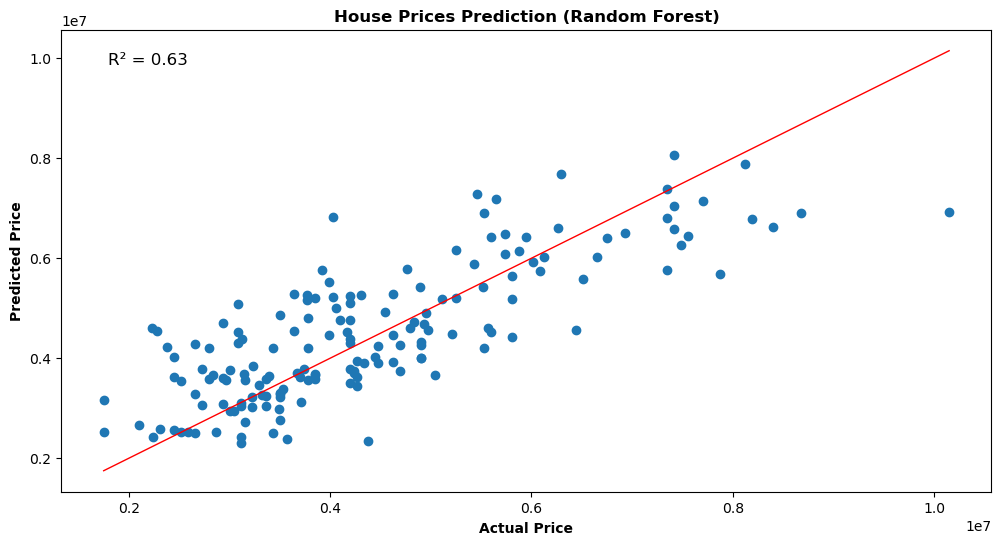

In [129]:
# Visualize the actual and predicted values from the RF model
plt.figure(figsize=(12,6))
plt.scatter(y_test, y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=1)

# Add labels to the plot
plt.title("House Prices Prediction (Random Forest)", fontweight="bold")
plt.xlabel("Actual Price", fontweight = "bold")
plt.ylabel("Predicted Price", fontweight= "bold")
plt.text(0.05, 0.95, f'R² = {r2_rf:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

In [119]:
# Feature importance for the RF model
features= model_pipe_rf.named_steps["onehotencoder"].get_feature_names_out()
importances = model_pipe_rf.named_steps["randomforestregressor"].feature_importances_

print(features[:5])
print(importances[:5])

['area' 'bedrooms' 'bathrooms' 'stories' 'parking']
[0.44836763 0.04306769 0.16659077 0.05338956 0.06950776]


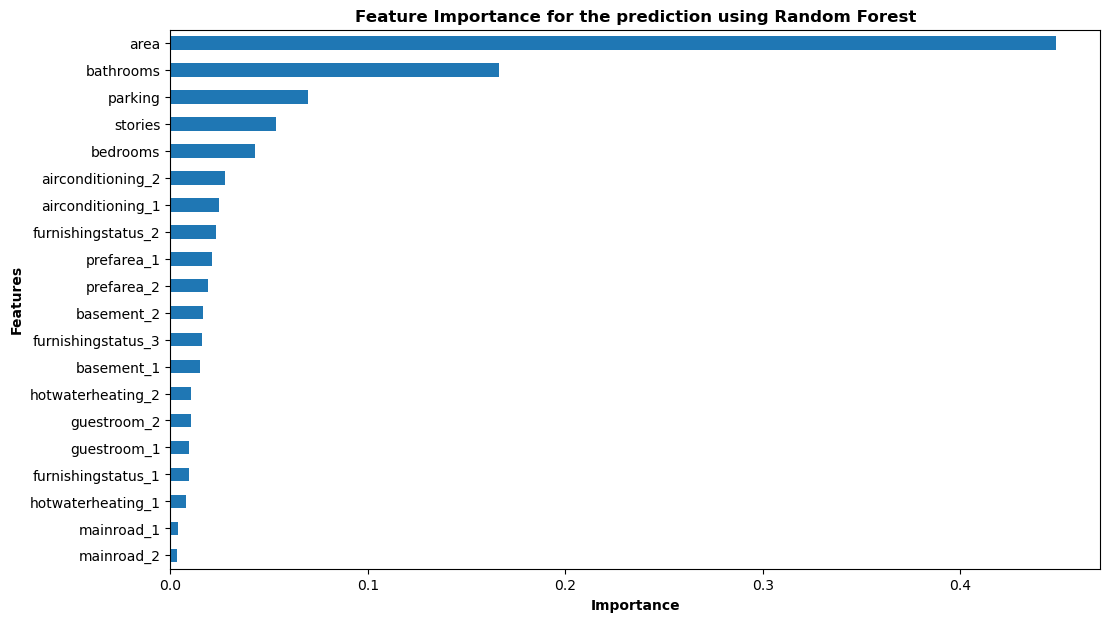

In [134]:
# Create a bar chart of the feature importance
f_importance = pd.Series(importances, index=features).sort_values()

fig, ax = plt.subplots(figsize=(12,7))

f_importance.plot(kind="barh", ax=ax)
plt.xlabel("Importance", fontweight="bold")
plt.ylabel("Features", fontweight= "bold")
plt.title("Feature Importance for the prediction using Random Forest", fontweight="bold");

## Compare the Results from Linear Regression and Random Forest Model

In [112]:
print(f"The mean absolute error of the LR model is: {mae_lr:.2f}")
print(f"The mean absolute error of the RF model is: {mae_rf:.2f}\n")


print(f"The root mean squared error for the LR model is {mse_lr:.2f}")
print(f"The root mean squared error for the RF model is {mse_rf:.2f}\n")

print(f"The R2 score of the LR model is: {r2_lr:.2f}")
print(f"The R2 score of the RF model is: {r2_rf:.2f}")

The mean absolute error of the LR model is: 713192.94
The mean absolute error of the RF model is: 747397.56

The root mean squared error for the LR model is 823898911494.51
The root mean squared error for the RF model is 933066838125.89

The R2 score of the LR model is: 0.67
The R2 score of the RF model is: 0.63
